In [438]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#read the csvs as dataframes
df_savant_raw = pd.read_csv('savant_data_2021_2023.csv')
df_people = pd.read_csv('lahman_people.csv')

In [371]:
#create column for year
df_savant_raw['year'] = df_savant_raw['game_date'].str[:4].astype(int)

In [765]:
#create dataframe for each at bat
at_bat_ids = df_savant_raw[['batter','pitcher','game_date','year','times_faced']].drop_duplicates()

#assign a unique id to each at bat
at_bat_ids['at_bat_id'] = range(1, len(at_bat_ids) + 1)

#add unique ids to original savant data
df_savant = df_savant_raw.merge(at_bat_ids, on=['batter','pitcher','game_date','year','times_faced'],how='inner')

In [766]:
#create dataframe for player season info
df_players = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)

#remove players without an mlb Id
df_players = df_players[df_players['player_mlb_id'].notna()]

In [767]:
#count total plate appearances for every batter per year
pa_counts = at_bat_ids.groupby(['batter','year'])['at_bat_id'].nunique().reset_index(name='total_pa')
df_players = df_players.merge(pa_counts,
                              left_on=['player_mlb_id','year'],
                              right_on=['batter','year'],
                              how='left').drop(columns='batter')
df_players['total_pa'] = df_players['total_pa'].fillna(0).astype(int)

#count total batters faced for every pitcher per year
bf_counts = at_bat_ids.groupby(['pitcher','year'])['at_bat_id'].nunique().reset_index(name='total_bf')
df_players = df_players.merge(bf_counts,
                              left_on=['player_mlb_id','year'],
                              right_on=['pitcher','year'],
                              how='left'
                             ).drop(columns='pitcher')
df_players['total_bf'] = df_players['total_bf'].fillna(0).astype(int)

In [768]:
#get count of pickoffs/steals that ended an inning 
basepath_outs = ['caught_stealing_3b' 'caught_stealing_2b', 'pickoff_caught_stealing_2b', 'pickoff_2b', 
'pickoff_caught_stealing_3b', 'pickoff_1b', 'caught_stealing_home', 'pickoff_3b', 'pickoff_caught_stealing_home']

df_basepath_ends_inning = df_savant[(df_savant['outs_when_up'] == 2) & (df_savant['events'].isin(basepath_outs))]
count_basepath_ended_ab = df_basepath_ends_inning.groupby(['batter','year'])['at_bat_id'].nunique().reset_index(name='base_ended_inn')

#remove those from plate appearances total
df_players = df_players.merge(count_basepath_ended_ab,
                              left_on=['player_mlb_id','year'],
                              right_on=['batter','year'],
                              how='left').drop(columns='batter')

df_players['base_ended_inn'] = df_players['base_ended_inn'].fillna(0)
df_players['total_pa'] = df_players['total_pa'] - df_players['base_ended_inn']

In [769]:
df_players['total_pa'].value_counts()

total_pa
0.0      5268
1.0        94
2.0        70
4.0        41
3.0        33
         ... 
178.0       1
209.0       1
598.0       1
589.0       1
137.0       1
Name: count, Length: 649, dtype: int64

<Axes: xlabel='total_pa', ylabel='Count'>

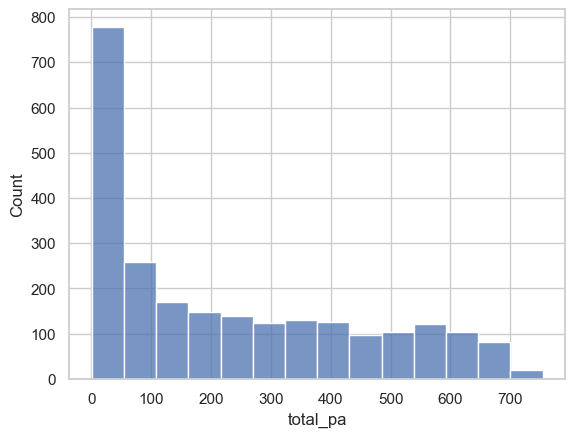

In [770]:
#plot of total plate appearances (min 1). Note this includes pitchers
sns.histplot(pa_counts['total_pa'])

<Axes: xlabel='total_bf', ylabel='Count'>

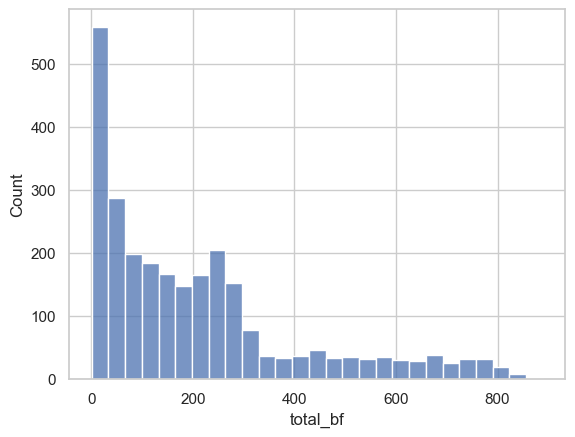

In [771]:
#plot of total batters faced (min 1). Note this includes position players
sns.histplot(bf_counts['total_bf'])

Now calculate what position(s) every player played at in the field (also need to do DH)

In [773]:
#get the fielders for every at bat
df_savant_fielding = df_savant[['at_bat_id','year','pitcher_1',
       'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9']].drop_duplicates()

# #what each position group means
# pitcher_1: MLB Player Id tied to the play event, anonymized via hashing
# fielder_2_1: MLB Player Id for catcher, anonymized via hashing
# fielder_3: MLB Player Id for 1B, anonymized via hashing
# fielder_4: MLB Player Id for 2B, anonymized via hashing
# fielder_5: MLB Player Id for 3B, anonymized via hashing
# fielder_6: MLB Player Id for SS, anonymized via hashing
# fielder_7: MLB Player Id for LF, anonymized via hashing
# fielder_8: MLB Player Id for CF, anonymized via hashing
# fielder_9: MLB Player Id for RF, anonymized via hashing

In [774]:
# # List of pitcher columns (or any other relevant columns)
# pitcher_columns = ['pitcher_1', 'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
#        'fielder_7', 'fielder_8', 'fielder_9']  # Modify this list as needed

# # Loop over the list of pitcher columns
# for pitcher_col in pitcher_columns:
#     # Compute the counts for each pitcher column
#     count_df = df_savant_fielding.groupby([pitcher_col, 'year']).size().reset_index(name='count')
    
#     # Merge the count data with df_players
#     df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[pitcher_col, 'year'])
    
#     # Fill NaN values with 0 and ensure the count is an integer
#     df_players['count'] = df_players['count'].fillna(0).astype(int)
    
#     # Optional: Rename the count column to differentiate between different pitcher columns
#     df_players.rename(columns={'count': f'count_{pitcher_col}'}, inplace=True)


In [777]:
# First, compute the counts

#list of each position column name
fielding_columns = ['pitcher_1', 'fielder_2_1', 'fielder_3', 
                    'fielder_4', 'fielder_5', 'fielder_6',
                    'fielder_7', 'fielder_8', 'fielder_9']

#dictionary to change position column to more recognizable name
fielding_dict = {'pitcher_1':'p', 'fielder_2_1':'c', 'fielder_3':'1b', 
                 'fielder_4':'2b', 'fielder_5':'3b', 'fielder_6':'ss',
                 'fielder_7':'lf', 'fielder_8':'cf', 'fielder_9':'rf'}

#get count for every player at every position
for col in fielding_columns:
    col_name = 'field_' + fielding_dict[col]
    count_df = df_savant_fielding.groupby([col, 'year']).size().reset_index(name=col_name)
    
    #add count to main dataframe
    df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)
    
    #fill NaN with 0
    df_players[col_name] = df_players[col_name].fillna(0).astype(int)


In [779]:
df_players.head()

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,...,base_ended_inn,field_p,field_c,field_1b,field_2b,field_3b,field_ss,field_lf,field_cf,field_rf
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,0.0,81,0,0,0,0,0,0,0,0
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,R,...,0.0,82,0,0,0,0,0,0,0,0
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,e195c4bc19cb6a08203e3c9e361677b73dbfdc03,2000,10,3,USA,185,74,L,R,...,0.0,0,0,0,0,0,0,0,0,0
3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,R,...,0.0,161,0,0,0,0,0,0,0,0
4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,R,...,0.0,0,0,4822,0,1,0,0,0,0


In [783]:
#calculate years after debut
df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[:4].astype(int)

In [785]:
df_players.columns

Index(['player_mlb_id', 'playerID_LAHMAN', 'birthYear', 'birthMonth',
       'birthDay', 'birthCountry', 'weight', 'height', 'bats', 'throws',
       'debut', 'birthDate', 'year', 'total_pa', 'total_bf', 'base_ended_inn',
       'field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 'field_ss',
       'field_lf', 'field_cf', 'field_rf', 'years_after_debut'],
      dtype='object')

In [786]:
def get_count_for_batter_event(df_player, df_sav, event, player_type):
    '''
        function to get number of occurances of an event in a year. 
        Returns the dataframe but with a new column

        parameters:
            df_player: baseball player dataframe
            df_sav = baseball savant dataframe
            event: event user is searching for
            player_type: pass either 'batter' or 'pitcher' depending on if searching for batter or pitcher stats
    '''
    #filter to specified event
    df_filter = df_sav[df_sav['events'] == event]

    #get event count for every batter/year combo
    col_name = player_type + '_' + event
    count_df = df_filter.groupby([player_type, 'year']).size().reset_index(name=col_name)

    #add column to main dataframe
    df_player = df_player.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[player_type, 'year']).drop(columns=player_type)
    df_player[col_name] = df_player[col_name].fillna(0).astype(int)

    return df_player

    #df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)

    

In [787]:
df_savant.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,...,delta_home_win_exp,delta_run_exp,role_key,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced,year,at_bat_id
0,FF,2021-04-05,93.2,0.84,5.74,c7c83eaa9fe8da2f81c5fce172059af61448b3e7,4f902241478a103f7a818f5be9a7b7ddf43cabb9,strikeout,swinging_strike,13.0,...,-0.014,-0.134,SP,1,0,97,22,3,2021,1
1,SL,2021-04-05,82.9,1.03,5.69,c7c83eaa9fe8da2f81c5fce172059af61448b3e7,4f902241478a103f7a818f5be9a7b7ddf43cabb9,NaN,foul,5.0,...,0.000,0.000,SP,1,0,96,22,3,2021,1
2,FF,2021-04-05,94.6,-1.85,5.77,514eeb6e6c17085fc1adabf03f1adca32318411f,afb9b85defc6fe5c3f48681480eff4d96ab723c7,caught_stealing_3b,ball,14.0,...,0.014,-0.202,SP,1,0,95,19,3,2021,2
3,FF,2021-04-05,97.1,1.86,6.57,875eeca87c6f80182a88c2a7b92c048b9e10b5e5,0f061b9439845159c394a71e55d635b10ca25656,field_out,hit_into_play,13.0,...,-0.007,-0.264,SP,1,0,95,22,3,2021,3
4,FF,2021-04-05,93.6,0.60,5.85,c7c83eaa9fe8da2f81c5fce172059af61448b3e7,4f902241478a103f7a818f5be9a7b7ddf43cabb9,NaN,ball,11.0,...,0.000,0.043,SP,1,0,95,22,3,2021,1


In [788]:
df_savant['events'].unique()

array(['strikeout', nan, 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b'], dtype=object)

In [789]:
#get counts for key batting events
batting_events = ['strikeout', 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b']

for event in batting_events:
    df_players = get_count_for_batter_event(df_players, df_savant, event, 'batter')


In [790]:
#get counts for key pitching events
batting_events = ['strikeout', 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b']

for event in batting_events:
    df_players = get_count_for_batter_event(df_players, df_savant, event, 'pitcher')


In [806]:
# Calculate new baseball stats
# Hits (already calculated)
df_players['hits'] = df_players['batter_single'] + df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']

# Eligible plate appearances
df_players['elig_pa'] = df_players['total_pa'] - df_players['batter_sac_fly'] - df_players['batter_sac_bunt'] - df_players['batter_walk'] - df_players['batter_hit_by_pitch']

# Batting Average (AVG)
df_players['avg'] = df_players['hits'] / df_players['elig_pa']

# Total Bases (TB)
df_players['tb'] = df_players['batter_single'] + 2 * df_players['batter_double'] + 3 * df_players['batter_triple'] + 4 * df_players['batter_home_run']

# Slugging Percentage (SLG)
df_players['slg'] = df_players['tb'] / df_players['elig_pa']

# On-Base Percentage (OBP)
df_players['obp'] = (df_players['hits'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch']) / \
                    (df_players['elig_pa'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch'] + df_players['batter_sac_fly'])

# On-Base Plus Slugging (OPS)
df_players['ops'] = df_players['obp'] + df_players['slg']

# Weighted On-Base Average (wOBA) - simplified
df_players['woba'] = (
    0.69 * df_players['batter_walk'] +
    0.72 * df_players['batter_hit_by_pitch'] +
    0.89 * df_players['batter_single'] +
    1.27 * df_players['batter_double'] +
    1.62 * df_players['batter_triple'] +
    2.10 * df_players['batter_home_run']
) / df_players['total_pa']

# Batting Average on Balls in Play (BABIP)
df_players['babip'] = (
    df_players['hits'] - df_players['batter_home_run']
) / (
    df_players['elig_pa'] - df_players['batter_walk'] - df_players['batter_hit_by_pitch'] - df_players['batter_home_run'] - df_players['batter_strikeout']
)

# Strikeout Rate (K%)
df_players['k_rate'] = df_players['batter_strikeout'] / df_players['elig_pa']

# Walk Rate (BB%)
df_players['bb_rate'] = df_players['batter_walk'] / df_players['elig_pa']

# Home Run Rate (HR%)
df_players['hr_rate'] = df_players['batter_home_run'] / df_players['elig_pa']

# Isolated Power (ISO)
df_players['iso'] = df_players['slg'] - df_players['avg']

# Extra Base Hits (XBH)
df_players['xbh'] = df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']

# Runs Created (RC) - simplified
df_players['rc'] = (df_players['hits'] + df_players['batter_walk']) * df_players['tb'] / df_players['elig_pa']

# Plate Appearances Per Strikeout (PA/K)
df_players['pa_per_k'] = df_players['elig_pa'] / df_players['batter_strikeout']

# Plate Appearances Per Walk (PA/BB)
df_players['pa_per_bb'] = df_players['elig_pa'] / df_players['batter_walk']

# Fielding Percentage (FP%)
df_players['fielding_percentage'] = df_players['field_p'] / \
    (df_players['field_p'] + df_players['batter_field_error'])

# Defensive Versatility (Number of Positions Played)
df_players['positions_played'] = df_players[['field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 
                                             'field_ss', 'field_lf', 'field_cf', 'field_rf']].gt(0).sum(axis=1)


In [ ]:
#Stats for pitchers

In [808]:
df_players['avg'].head()

0         NaN
1    0.333333
2         NaN
3         NaN
4    0.261023
Name: avg, dtype: float64

In [830]:
def linear_regression_scatter(df, x, y, min_x=False, min_y=False):
    
    #filter entries to where columns aren't null
    df = df[df[x].notnull() & df[y].notnull()]

    #filter out player who do not meet the min
    if min_x != False:
        df = df[df[x] >= min_x]
    
    if min_y != False:
        df = df[df[y] >= min_y]
    
    #get passed columns 
    x_vals = df[x]
    y_vals = df[y]
    
    #perform linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_vals, y_vals)
    
    #define regression function
    def myfunc(x_vals):
        return slope * x_vals + intercept
    
    #generate regression line values
    mymodel = list(map(myfunc, x_vals))
    
    #create scatter plot with regression line
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    sns.set_theme(style="whitegrid")  # Use a clean theme
    
    #scatter plot
    sns.scatterplot(x=x_vals, y=y_vals, color="blue", alpha=0.6, s=60, label="Player Data")
    
    #regression line
    plt.plot(x_vals, mymodel, color="red", linewidth=2, label=f"Regression Line (a: {slope:.2f}, b: {intercept:.2f}, R²={r**2:.2f})")
    
    #add text and plot
    plt.title(f"Relationship Between {x} and {y}", fontsize=16)
    plt.xlabel(f"{x}", fontsize=14)
    plt.ylabel(f"{y}", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

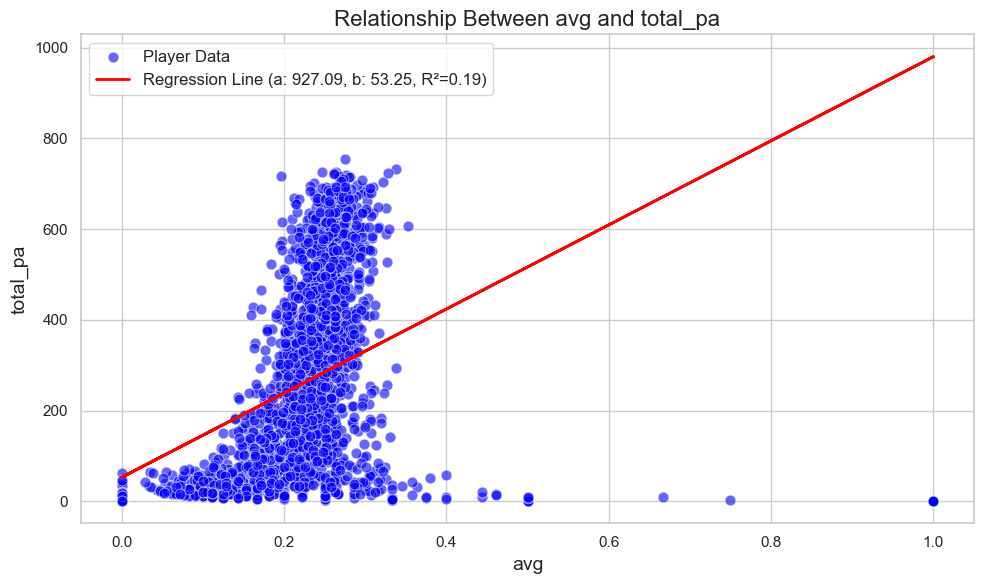

In [834]:
linear_regression_scatter(df_players,'avg','total_pa')

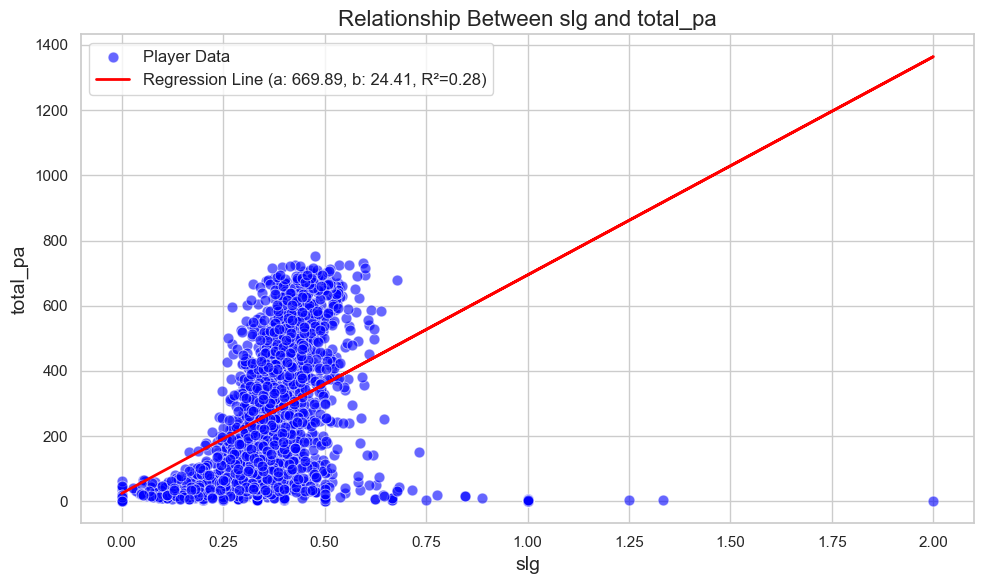

In [814]:
linear_regression_scatter(df_players,'slg','total_pa')

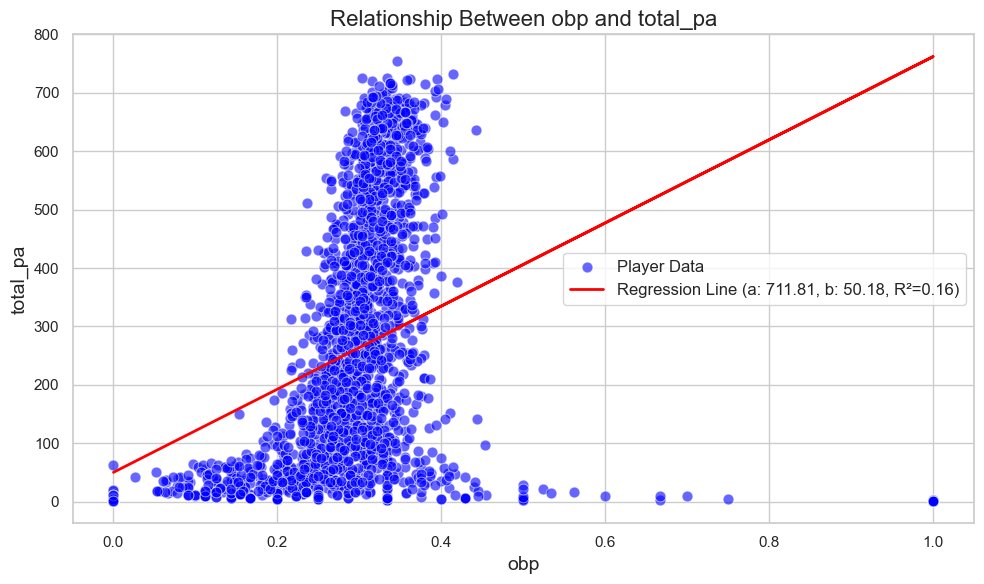

In [815]:
linear_regression_scatter(df_players,'obp','total_pa')

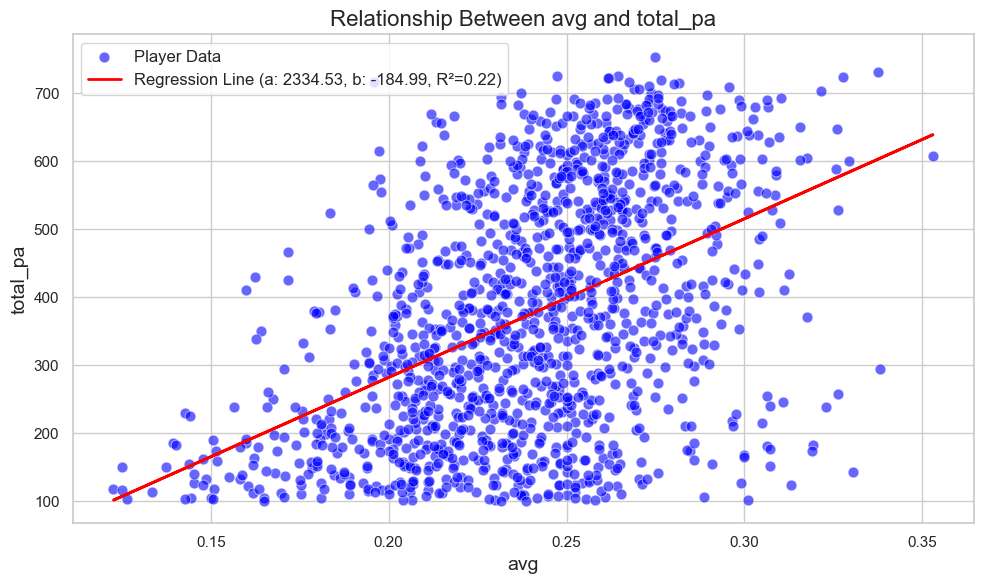

In [836]:
linear_regression_scatter(df_players,'avg','total_pa', min_y=100)